In [3]:
import numpy as np
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt


In [4]:
class traj:
    def __init__(self, box_size, positions,types):
        self.box_size =box_size
        self.positions=positions
        
        self.types=types
N_particles=10000
def read_lammpstrj(filename,N_particles):
    f=open(filename)
    Lines=f.readlines()
    n_timestep=int(len(Lines)/(N_particles+9))
    box_size=np.zeros((n_timestep,3))
    positions=np.zeros((n_timestep,N_particles,3))
    types=np.zeros((n_timestep,N_particles))
    count = 0

    for line in Lines:
        n_t=int(count/(N_particles+9))
        separate=line.split()
        if count%(9+N_particles)==5:
            box_size[n_t][0]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)==6:
            box_size[n_t][1]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)==7:
            box_size[n_t][2]=float(separate[1])-float(separate[0])
        if count%(9+N_particles)>=9:
            n_p=int(separate[0])-1
            types[n_t][n_p]=float(separate[1])
            positions[n_t][n_p][0]=float(separate[2])
            positions[n_t][n_p][1]=float(separate[3])
            positions[n_t][n_p][2]=float(separate[4])
            
        count+=1
    return traj(box_size=box_size,positions=positions,types=types) 
a=read_lammpstrj('nanorod_Dump.lammpstrj',N_particles)

In [5]:
frame1=a.positions[100]
dims=a.box_size[0]

In [6]:
def true_distance_vectorized(points, L):
    # Calculate the pairwise distance differences considering periodic boundary conditions
    delta = np.abs(points[:, np.newaxis, :] - points[np.newaxis, :, :])
    delta = np.where(delta > L / 2, L - delta, delta)
    # Compute the Euclidean distances
    distances = np.linalg.norm(delta, axis=-1)
    return distances

In [7]:
def compute_pairwise_distances(frame,L,N_particles):
    distances_matrix = true_distance_vectorized(frame,L)
    i_upper, j_upper = np.triu_indices(N_particles, k=1)
    pairwise_distances = distances_matrix[i_upper, j_upper]
    index = np.argwhere(pairwise_distances>dims[0]/2)
    pairwise_distances = np.delete(pairwise_distances, index)
    return pairwise_distances

In [8]:

distances=compute_pairwise_distances(frame1,dims[0],10000)

In [9]:
def calculate_g_r_frame(frame,L,N_particles,dr,minr,maxr):
    distances=compute_pairwise_distances(frame,L,N_particles)
    n_bins=int((maxr-minr)/dr)
    rho=N_particles/(L**3)
    N_r,radiir,index=binned_statistic(distances,distances,statistic='count',bins=n_bins,range=[minr,maxr])
    midr = (radiir[:-1] + radiir[1:]) / 2
    g_r=N_r*2/(N_particles*4*np.pi*midr*midr*dr*rho)
    return g_r, midr

In [10]:
g_r,midr=calculate_g_r_frame(frame1,dims[0],10000,0.1,0,dims[0]/2)

(0.0, 200.0)

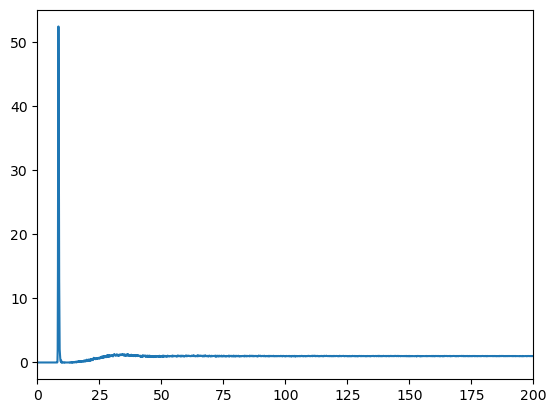

In [11]:
plt.plot(midr,g_r)
ax = plt.gca()
ax.set_xlim([0, 200])


In [12]:
rho=N_particles/(dims[0]**3)

In [13]:
#number of bins
dr=0.1
nb=g_r.shape[0]
integrand_padded = np.zeros(nb*2)
integrand=(g_r-1)*midr
integrand_padded[:nb]=integrand
# Compute the Fourier Transform of the histogram
fft_result = np.fft.fft(integrand_padded)
fft_freqs = np.fft.fftfreq(2*nb, d=0.1)
S_q=1-4*np.pi*rho*fft_result.imag*dr/(fft_freqs)


/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/2916548178.py:10: RuntimeWarning: divide by zero encountered in divide
  S_q=1-4*np.pi*rho*fft_result.imag*dr/(fft_freqs)


/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/270391299.py:3: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0, 0.1])


(0.0009838747467044435, 0.1)

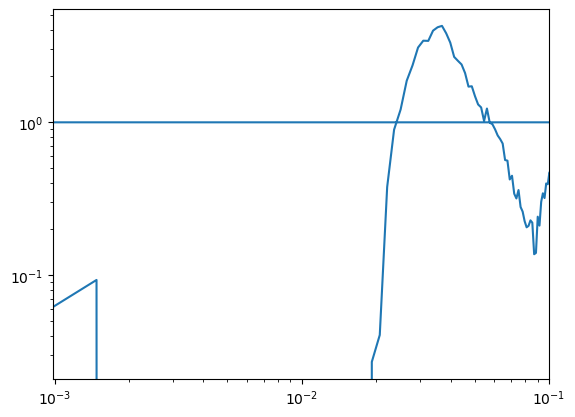

In [40]:
plt.loglog(fft_freqs,S_q)
ax = plt.gca()
ax.set_xlim([0, 0.1])

In [24]:
def Calculate_S_q_frame(frame,L,N_particles,dr,minr,maxr):
    nb=0.1*int((maxr-minr)/dr)#number of bins
    maxq=0.2*np.pi/dr
    dq=maxq/nb
    qarray=np.arange(0,maxq,dq)
    distance_array=compute_pairwise_distances(frame,L,N_particles)
    S_q_list = []
    for q in qarray:
        S_q = (-2/( N_particles*q)) * np.sum(np.sin(q * distance_array)/distance_array)
        S_q_list.append(S_q)
        print(S_q)
        
    S_q_array = np.array(S_q_list)
    return qarray, S_q_array
    

In [25]:
qarray,S_q_array=Calculate_S_q_frame(frame1,dims[0],N_particles=10000,dr=0.1,minr=0,maxr=dims[0]/2)

/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/2723973220.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  S_q = (-2/( N_particles*q)) * np.sum(np.sin(q * distance_array)/distance_array)
/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/2723973220.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  S_q = (-2/( N_particles*q)) * np.sum(np.sin(q * distance_array)/distance_array)


nan
398.27190049472256
99.92063350449587
44.73036186107092
25.346070576813776
16.266209356207334
11.256540726357926
8.270359439275625
6.230316755016708
4.769634119429135
3.6439638176530136
2.903084995214007
2.256210334816943
1.9085623623214134
1.7663344335190494
1.5506635857537436
1.4445406839495674
1.3040356322973374
1.191750985053027
1.0686251678924519
1.002391957979799
0.933972038251322
0.8689449538739205
0.8251435518140108
0.7811844953311036
0.7472180173379352
0.7052173547796152
0.6706027947450418
0.6343449565566478
0.5977525157265271
0.5785603452219369
0.5388019567465295
0.492095541982455
0.4595321115728319
0.42640629738717595
0.39047079606351
0.36636386467109683
0.3359782580283704
0.29750375470572976
0.2722254538095934
0.2396155780361926
0.2183711210998173
0.19034355929389202
0.16961521993936446
0.16098437011850586
0.129635850674213
0.11958304333540164
0.10716313310204248
0.09031079277946935
0.09249250340714318
0.08120948368461234
0.08672246167382523
0.08453339905476882
0.0762430

(0.0, 10.0)

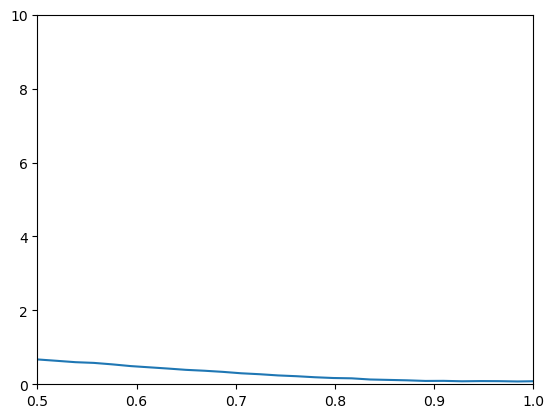

In [28]:
plt.plot(qarray,S_q_array)
ax = plt.gca()
ax.set_xlim([0.5, 1])
ax.set_ylim([0, 10])

In [38]:
qarray

array([0.        , 0.01856185, 0.03712369, 0.05568554, 0.07424739,
       0.09280924, 0.11137108, 0.12993293, 0.14849478, 0.16705663,
       0.18561847, 0.20418032, 0.22274217, 0.24130401, 0.25986586,
       0.27842771, 0.29698956, 0.3155514 , 0.33411325, 0.3526751 ,
       0.37123695, 0.38979879, 0.40836064, 0.42692249, 0.44548433,
       0.46404618, 0.48260803, 0.50116988, 0.51973172, 0.53829357,
       0.55685542, 0.57541727, 0.59397911, 0.61254096, 0.63110281,
       0.64966466, 0.6682265 , 0.68678835, 0.7053502 , 0.72391204,
       0.74247389, 0.76103574, 0.77959759, 0.79815943, 0.81672128,
       0.83528313, 0.85384498, 0.87240682, 0.89096867, 0.90953052,
       0.92809236, 0.94665421, 0.96521606, 0.98377791, 1.00233975,
       1.0209016 , 1.03946345, 1.0580253 , 1.07658714, 1.09514899,
       1.11371084, 1.13227268, 1.15083453, 1.16939638, 1.18795823,
       1.20652007, 1.22508192, 1.24364377, 1.26220562, 1.28076746,
       1.29932931, 1.31789116, 1.336453  , 1.35501485, 1.37357

In [43]:
def py(qr, eta):
    a = np.power(1 + 2 * eta, 2) / np.power(1 - eta, 4)
    b = -6 * eta * np.power(1 + eta / 2, 2) / np.power(1 - eta, 4)
    c = eta / 2 * np.power(1 + 2 * eta, 2) / np.power(1 - eta, 4)
    A = 2 * qr
    A2 = A * A
    G = (a / A2 * (np.sin(A) - A * np.cos(A))
         + b / (A * A2) * (2 * A * np.sin(A) + (2 - A2) * np.cos(A) - 2)
         + c / np.power(A, 5) * (-np.power(A, 4) * np.cos(A) + 4 * ((3 * A2 - 6) * np.cos(A) + A * (A2 - 6) * np.sin(A) + 6)))
    
    return 1 / (1 + 24 * eta * G / A)
qr=np.arange(0,10,0.1)
S_q=py(qr,0.3)

/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/3248217906.py:7: RuntimeWarning: divide by zero encountered in divide
  G = (a / A2 * (np.sin(A) - A * np.cos(A))
/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/3248217906.py:7: RuntimeWarning: invalid value encountered in multiply
  G = (a / A2 * (np.sin(A) - A * np.cos(A))
/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/3248217906.py:8: RuntimeWarning: divide by zero encountered in divide
  + b / (A * A2) * (2 * A * np.sin(A) + (2 - A2) * np.cos(A) - 2)
/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/3248217906.py:8: RuntimeWarning: invalid value encountered in multiply
  + b / (A * A2) * (2 * A * np.sin(A) + (2 - A2) * np.cos(A) - 2)
/var/folders/nl/0wymk6gn3bs5t88nh2hh2n400000gn/T/ipykernel_96213/3248217906.py:9: RuntimeWarning: divide by zero encountered in divide
  + c / np.power(A, 5) * (-np.power(A, 4) * np.cos(A) + 4 * ((3 * A2 - 6) * np.cos(A) + A * (A2 - 6) * 

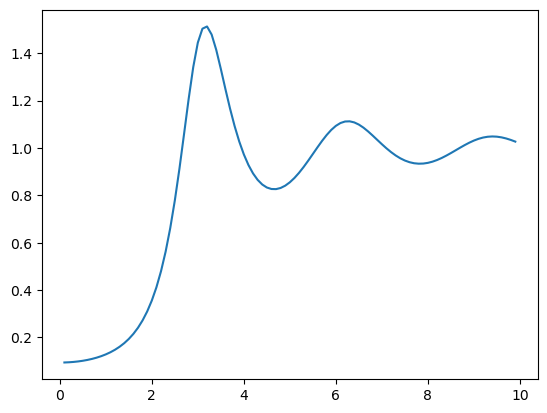

In [44]:
plt.plot(qr,S_q)